In [44]:
# import pandas as pd
# import numpy as np
from sklearn.model_selection import train_test_split
# from IPython.display import display

# import torch

# # تحميل البيانات
# cols_dict = {
#     'ratings': ['user_id', 'movie_id', 'rating', 'timestamp'],
#     'users': ['user_id', 'gender', 'age', 'occupation', 'zip_code'],
#     'items': ['movie_id', 'title', 'genre']
# }
# dir = 'C:/Users/lenovo/Desktop/LinUCB-HybridRecommender/data/1m/'

# ratings_data = pd.read_csv(dir + 'ratings.dat', sep='::', names=cols_dict['ratings'], engine='python')
# users_data = pd.read_csv(dir + 'users.dat', sep='::', names=cols_dict['users'], engine='python')
# items_data = pd.read_csv(dir + 'movies.dat', sep='::', names=cols_dict['items'], encoding='latin-1', engine='python')

# display(ratings_data.head(3), users_data.head(3), items_data.head(3))
# print(ratings_data.shape, users_data.shape, items_data.shape)


In [45]:
import pandas as pd
import torch

# تعريف هيكل البيانات
cols_dict = {
    'ratings': ['user_id', 'movie_id', 'rating', 'timestamp'],
    'users': ['user_id', 'gender', 'age', 'occupation', 'zip_code'],
    'items': ['movie_id', 'title', 'genre']
}

dir = 'C:/Users/lenovo/Desktop/LinUCB-HybridRecommender/data/100k/'  # تغيير المسار هنا

ratings_data = pd.read_csv(dir + 'u.data', sep='\t', names=cols_dict['ratings'], engine='python')
users_data = pd.read_csv(dir + 'u.user', sep='|', names=cols_dict['users'],  engine='python')
items_data = pd.read_csv(dir + 'u.item', sep='|', names=cols_dict['items'] + ['other_details'], encoding='latin-1' , engine='python')

# تنظيف بيانات الأفلام (قد تختلف حسب هيكل ملف u.item)
items_data = items_data[cols_dict['items']]  # الاحتفاظ بالأعمدة المطلوبة فقط

# أسماء الأعمدة كما في u.item
genre_labels = [
    'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
    'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

item_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL'] + genre_labels

# تحميل ملف u.item
items_data_raw = pd.read_csv(dir + 'u.item', sep='|', names=item_columns, encoding='latin-1', engine='python')

# إنشاء عمود genre الجديد كنص مثل MovieLens 1M
def get_genres(row):
    return '|'.join([genre for genre, flag in zip(genre_labels, row[genre_labels].values) if flag == 1])

# نسخ العمودين المطلوبين فقط
items_data = items_data_raw[['movie_id', 'title']].copy()
items_data['genre'] = items_data_raw.apply(get_genres, axis=1)

# Display the result
print("Data shape after genre conversion:")
display(items_data.head(3))

print("Data uploaded successfully!")
print(f"Data dimensions: {ratings_data.shape} (ratings), {users_data.shape} (users), {items_data.shape} (movies)")
    

display(ratings_data.head(3))
display(users_data.head(3))
display(items_data.head(3))
# Additional information about the data
print("\nAdditional information:")
print(f"Number of unique users: {ratings_data['user_id'].nunique()}")
print(f"Number of unique movies: {ratings_data['movie_id'].nunique()}")
print(f"Ratings time range: from {pd.to_datetime(ratings_data['timestamp'], unit='s').min()} to {pd.to_datetime(ratings_data['timestamp'], unit='s').max()}")

Data shape after genre conversion:


,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,GoldenEye (1995),Action|Adventure|Thriller
2,3,Four Rooms (1995),Thriller


Data uploaded successfully!
Data dimensions: (100000, 4) (ratings), (943, 5) (users), (1682, 3) (movies)


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116


,user_id,gender,age,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067


,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,GoldenEye (1995),Action|Adventure|Thriller
2,3,Four Rooms (1995),Thriller



Additional information:
Number of unique users: 943
Number of unique movies: 1682
Ratings time range: from 1997-09-20 03:05:10 to 1998-04-22 23:10:38


In [46]:
print(ratings_data.shape, users_data.shape, items_data.shape)

users_data_og = users_data.copy(deep=True)
items_data_og = items_data.copy(deep=True)
ratings_data_og = ratings_data.copy(deep=True)
print(users_data.columns)
print(items_data.columns)
print(ratings_data.columns)

(100000, 4) (943, 5) (1682, 3)
Index(['user_id', 'gender', 'age', 'occupation', 'zip_code'], dtype='object')
Index(['movie_id', 'title', 'genre'], dtype='object')
Index(['user_id', 'movie_id', 'rating', 'timestamp'], dtype='object')


In [47]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
from typing import Literal, Union
import matplotlib.pyplot as plt

from sklearn.metrics import ndcg_score
from sklearn.metrics.pairwise import cosine_similarity

class Utils:
    @staticmethod
    def extract_year(items_df: pd.DataFrame) -> pd.DataFrame:
        '''
        Extracts:
            - Year from title
        returns: Dataframes with extracted features
        '''
        # Extract year from title
        items_df['year'] = items_df['title'].str.extract(r'\((\d{4})\)')
        # Convert to numeric (will keep NaN for missing values)
        items_df['year'] = pd.to_numeric(items_df['year'], errors='coerce')
        return items_df

    @staticmethod
    def extract_category_avg_ratings(users_df: pd.DataFrame, items_df: pd.DataFrame, ratings_df: pd.DataFrame, k=0.6) -> pd.DataFrame:
        '''
        Extracts penalized average ratings for each category for each user using exponential decay penalty.

        users_df: DataFrame containing user information.
        items_df: DataFrame containing item information with categories as binary columns.
        ratings_df: DataFrame containing user-item interactions and ratings.
        k: Control factor for penalty steepness. Default is 0.6.

        Returns a DataFrame with users and their penalized average ratings per category.
        '''
        # Create a copy of users_df to store features
        features_df = users_df.copy()

        def exp_penalty(n, k=0.6):
            return 1 / np.exp(k * n)

        for category in items_df.columns[2:]:
            category_items = items_df[items_df[category] == 1]['movie_id']

            category_ratings = ratings_df[ratings_df['movie_id'].isin(category_items)]

            user_stats = category_ratings.groupby('user_id')['rating'].agg(['mean', 'count']).reset_index()
            user_stats.columns = ['user_id', f'user_avg_rating_{category}', f'count_rating_{category}']

            features_df = pd.merge(features_df, user_stats, on='user_id', how='left')

            features_df[f'user_avg_rating_{category}'] = np.where(
                features_df[f'count_rating_{category}'] > 0,
                (1 - exp_penalty(features_df[f'count_rating_{category}'], k)) * features_df[f'user_avg_rating_{category}'],
                features_df[f'user_avg_rating_{category}']
            )

            features_df[f'user_avg_rating_{category}'] = features_df[f'user_avg_rating_{category}'].fillna(0)

        cols = features_df.columns[:32].tolist() + [col for col in features_df.columns if col.startswith('user_avg_rating_')]
        result_df = features_df[cols]

        return result_df

    @staticmethod
    def extract_category_freq(users_df: pd.DataFrame, items_df: pd.DataFrame, ratings_df: pd.DataFrame) -> pd.DataFrame:
        # Copy users_df to avoid modifying the original dataframe
        freq_df = users_df.copy()

        # Get total interactions for each user
        total_interactions = ratings_df.groupby('user_id').size().reset_index(name='total_interactions')
        freq_df = pd.merge(freq_df, total_interactions, on='user_id', how='left').fillna(0)

        # Iterate over each category in the items_df (assuming categories are from the 3rd column onward)
        for category in items_df.columns[2:]:
            # Get movie_ids that belong to the current category
            movie_ids_in_category = items_df[items_df[category] == 1]['movie_id']

            # Count interactions in the current category for each user
            category_interactions = ratings_df[ratings_df['movie_id'].isin(movie_ids_in_category)].groupby('user_id').size().reset_index(name=f'{category}_count')

            # Merge category_interactions with freq_df
            freq_df = pd.merge(freq_df, category_interactions, on='user_id', how='left').fillna(0)

            # Calculate frequency of interactions for the current category
            freq_df[f'freq_{category}'] = freq_df[f'{category}_count'] / freq_df['total_interactions']

            # Drop the intermediate category count column
            freq_df.drop(columns=[f'{category}_count'], inplace=True)

        return freq_df.fillna(0).drop(columns=['total_interactions'])

    @staticmethod
    def extend_users_items(users_df: pd.DataFrame, items_df: pd.DataFrame, ratings_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
        '''
        Extends users and items dataframes to match the ratings dataframe
        '''
        # Extend users dataframe
        users_df = pd.merge(users_df, ratings_df[['user_id']], on='user_id', how='right')

        # Extend items dataframe
        items_df = pd.merge(items_df, ratings_df[['movie_id']], on='movie_id', how='right')

        return users_df, items_df

    @staticmethod
    def multi_hot_encode(df: pd.DataFrame, col: str, delimiter='|') -> pd.DataFrame:
        df_ = df.copy(deep=True)

        # معالجة قيم genre
        if col == 'genre':
            df_[col] = df_[col].fillna('Unknown').str.replace("Children's", 'Children')

        df_[col] = df_[col].str.split(delimiter)
        pivot_df = df_.explode(col).pivot_table(index='movie_id', columns=col, aggfunc='size', fill_value=0).reset_index()
        result = pd.merge(df, pivot_df, on='movie_id', how='left')

        return result.drop(columns=[col])

    @staticmethod
    def one_hot_encode(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
        '''
        One hot encodes columns in a dataframe
        '''
        return pd.get_dummies(df, columns=cols) * 1

    @staticmethod
    def move_column(df: pd.DataFrame, col: list[str], pos: int) -> pd.DataFrame:
        '''
        Moves a column to a specific position in a DataFrame
        '''
        cols = df.columns.tolist()
        for i in reversed(col):
            cols.insert(pos, cols.pop(cols.index(i)))
        return df[cols]

    @staticmethod
    def preprocess_user(user: dict, num_items: int, users: np.ndarray, weights: list[np.ndarray]=None, topk: int=3, verbose=False) -> tuple[torch.IntTensor, torch.FloatTensor, Union[list[np.ndarray], None], Union[np.ndarray, None]]:
        '''
        Preprocesses user data for model input
        '''
        if 'age' not in user or not user['age']:
            user_ = users[user['id'] - 1]
            user_ = np.insert(user_, 0, user['id'])
            print(f"User id: {user['id']} top {topk} genres: {np.array(genre)[np.argsort(user_[-18:])[-topk:][::-1]]}") if verbose else None
            user_ = np.tile(user_, (num_items, 1))
            return torch.IntTensor(user_[:, 0]), torch.FloatTensor(user_[:, 1:]), None, np.array(genre)[np.argsort(user_[0, -18:])[-topk:][::-1]]

        user_ = np.zeros(31, dtype=float)

        user_[0] = user['id']

        user_[1 if user['gender'] == 'M' else 2] = 1

        user_[3 + occupation.index(user['occupation'])] = 1

        # map age to bins
        user['age'] = 1 if user['age'] < 18 else 18 if user['age'] < 25 else 25 if user['age'] < 35 else 35 if user['age'] < 45 else 45 if user['age'] < 56 else 56

        user_[3 + len(occupation) + age.index(user['age'])] = 1

        avg_ratings = np.zeros(len(genre), dtype=float) # 18 genres

        for genre_ in user['genres']:
            avg_ratings[genre.index(genre_)] = 1.0

        user_ = np.concatenate((user_, avg_ratings))

        # Get top 10 users ids of users with similar intrests (cosine similarity)
        similar_users_ids = cosine_similarity(user_[1:].reshape(1, -1), users).argsort()[0][-10:]

        # Get the mean embeddings of the top 10 similar users
        mlp_weights = weights[0][similar_users_ids].mean(axis=0)
        mf_weights = weights[1][similar_users_ids].mean(axis=0)

        user_ = np.tile(user_, (num_items, 1))
        return torch.IntTensor(user_[:, 0]), torch.FloatTensor(user_[:, 1:]), [mlp_weights, mf_weights], None

    @staticmethod
    def preprocess_items(items: pd.DataFrame) -> pd.DataFrame:
        '''
        Preprocesses items data for model input
        '''
        # multi hot encode genres
        items_ = Utils.multi_hot_encode(items, 'genre')
        items_ = Utils.extract_year(items_)
        items_['year'] = items_['year'] / items_['year'].max()
        items_ = items_.drop(['title'], axis=1)

        return items_

    @staticmethod
    def remove_missing_values(ratings: pd.DataFrame, items: pd.DataFrame) -> tuple[pd.DataFrame]:
        '''
        Removes rows with missing values from items and ratings dataframes
        '''
        # Get item ids with missing release dates
        nan_item_ids = items[items[['release_date']].isna().any(axis=1)]['item_id']

        # Remove movies with missing release dates
        items.dropna(subset=['release_date'], inplace=True)

        # remove ratings of missing items
        ratings = ratings[~ratings['item_id'].isin(nan_item_ids)]

        return ratings, items

    @staticmethod
    def negative_sampling(ratings: pd.DataFrame, items: pd.DataFrame, num_negatives: int) -> pd.DataFrame:
        '''
        Sample negative items for each user
        '''
        # All Movie ids
        all_items = items['movie_id'].values

        negative_samples = []
        for user_id in ratings['user_id'].unique():
            # Movie ids that the user has interacted with
            pos_items = ratings[ratings['user_id'] == user_id]['movie_id'].values

            # Movie ids that the user has not interacted with
            unrated_items = np.setdiff1d(all_items, pos_items)

            # Sample negative items
            neg_items = np.random.choice(unrated_items, size=num_negatives, replace=False)

            # Create negative samples
            for item_id in neg_items:
                negative_samples.append([user_id, item_id, 0])

        negative_samples = pd.DataFrame(negative_samples, columns=['user_id', 'movie_id', 'rating'])

        ratings['rating'] = [1] * ratings.shape[0]

        return pd.concat([ratings, negative_samples], ignore_index=True)

    @staticmethod
    def ndcg_hit_ratio(y_preds, X_test_users, y_true, k=10):  # تغيير هنا: قيمة افتراضية لـ k
        '''
        Compute NDCG and Hit Ratio
        '''
        if k is None:  # إضافة تحقق
            k = 10

        unique_users = np.unique(X_test_users, axis=0)
        hits = 0
        total_users = len(unique_users)

        y_preds_padded = []
        y_true_padded = []
        for user in unique_users:
            user_indices = np.where((X_test_users == user).all(axis=1))[0]
            user_preds = y_preds[user_indices][:k].flatten()
            user_true = y_true[user_indices][:k].flatten()

            if np.any(user_true == 1):
                hits += 1

            if len(user_preds) < k:
                user_preds = np.pad(user_preds, (0, k - len(user_preds)), mode='constant', constant_values=-1e10)
            if len(user_true) < k:
                user_true = np.pad(user_true, (0, k - len(user_true)), mode='constant', constant_values=0)

            y_preds_padded.append(user_preds)
            y_true_padded.append(user_true)

        ndcg = ndcg_score(y_true_padded, y_preds_padded, k=k)
        hit_ratio = hits / total_users
        return ndcg, hit_ratio



    @staticmethod
    def pipeline(request: any, model: nn.Module, weights: list[np.ndarray], users: np.ndarray, movies: pd.DataFrame, movies_og: pd.DataFrame, ratings: pd.DataFrame, mode: str) -> tuple[list[dict], Union[np.ndarray, None]]:
        '''
        Pipeline for inference
        '''
        num_items = 300 # Number of items to retrieve
        request = request if isinstance(request, dict) else request.model_dump()

        # preprocess the old user
        user_id, user, weights, top_n_genres = Utils.preprocess_user(
                                        user=request,
                                        num_items=num_items,
                                        users=users,
                                        weights=weights
                                        )
        user_id, user = user_id.to(model.device), user.to(model.device)

        movies = Utils.retrieve(
            movies=movies,
            user=user.detach().cpu().numpy(),
            num_genres=len(request['genres']) if request['genres'] else 3,
            k=num_items,
            random_state=0
        )

        movie_ids, movies = Utils.filter(
            movies=movies,
            ratings=ratings,
            user_id=request['id']
        )
        movie_ids, movies = movie_ids.to(model.device), movies.to(model.device)

        y_pred = model(
            user_id[:len(movies)],
            movie_ids,
            user[:len(movies)],
            movies,
            weights
        ).cpu().detach().numpy()

        movies_retrieved = movies_og[movies_og['movie_id'].isin(movie_ids.cpu().numpy())].sort_values(by='movie_id', key=lambda x: pd.Categorical(x, categories=movie_ids.cpu().numpy(), ordered=True))

        return Utils.order(y_pred, movies_retrieved, mode, top_k=request['top_k']).to_dict(orient='records'), top_n_genres

    @staticmethod
    def retrieve(movies: pd.DataFrame, user: np.ndarray, k: int, num_genres: int=3, random_state: int=42) -> pd.DataFrame:
        '''
        Retrieve top k movies based on genres based on this equation:
        ```
        num_movies_per_genre = k // (len(genres) + 1) # +1 for the most popular genre
        ```

        Example:
        If k = 100 and genres = ['Action', 'Adventure', 'Animation'], then:
        25 movies will be retrieved for each genre and 25 for the most popular genre.

        movies: DataFrame containing movie information.
        genres: List of genres to retrieve movies for.
        k: Number of movies to retrieve.

        Returns a DataFrame containing the top k movies based on the specified genres.
        '''


    @staticmethod
    def filter(movies: pd.DataFrame, ratings: pd.DataFrame, user_id: int) -> tuple[torch.IntTensor, torch.FloatTensor]:
        '''
        Filter movies that the user has not interacted with, and remove duplicates
        '''
        # Get movie ids that the user has interacted with
        user_movies = ratings[ratings['user_id'] == user_id]['movie_id'].values

        # Filter movies that the user has not interacted with
        movies = movies[~movies['movie_id'].isin(user_movies)]

        # Remove duplicates
        movies = movies.drop_duplicates(subset=['movie_id'])

        return torch.IntTensor(movies['movie_id'].values), torch.FloatTensor(movies.drop(columns=['movie_id']).values)

    @staticmethod
    def order(y_pred: np.ndarray, movies: pd.DataFrame, mode: Literal['explicit', 'implicit'], top_k=10) -> list[dict]:
        '''
        Order the predictions
        '''
        col_name= 'predicted_rating' if mode == 'explicit' else 'predicted_score'
        sorted_index = np.argsort(-y_pred, axis=0).reshape(-1).tolist()
        y_pred = y_pred[sorted_index]
        sorted_movies = movies.iloc[sorted_index]
        sorted_movies = sorted_movies.copy()
        sorted_movies[col_name] = y_pred if mode == 'implicit' else y_pred * 5
        sorted_movies.reset_index(drop=True, inplace=True)
        sorted_movies[col_name] = sorted_movies[col_name].apply(lambda x: round(x, 2))

        return sorted_movies.head(top_k)

    @staticmethod
    def plot_metrics(history: dict, title: str, figsize: tuple=(12, 4)) -> None:
        '''
        Plot the training and validation losses in one figure and the other metrics in another figure
        '''
        fig, ax = plt.subplots(1, 2, figsize=figsize)
        ax[0].plot(history['loss'], label='Train Loss')
        ax[0].plot(history['val_loss'], label='Validation Loss')
        ax[0].set_title('Training and Validation Loss')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].legend()

        # Metrics plot
        for metric, values in history.items():
            if metric not in ['loss', 'val_loss']:
                ax[1].plot(values, label=metric)

        ax[1].set_title('Metrics')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Value')
        ax[1].legend()
        plt.suptitle(title)
        plt.show()

class EarlyStopping:
    """
    Early stopping to stop the training when the loss does not improve after a certain number of epochs (patience).
    """
    def __init__(self, patience=3, delta=0, verbose=False, path='checkpoint.pth') -> None:
        """
        Args:
            patience (int): How many epochs to wait after the last time the validation loss improved.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            verbose (bool): If True, prints a message for each validation loss improvement.
            path (str): Path for the checkpoint to be saved to.
        """
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.path = path
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss, model: nn.Module) -> None:
        '''
        Call method
        '''
        score = -val_loss

        if not self.best_score:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}') if self.verbose else None
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model: nn.Module) -> None:
        '''
        Save the model checkpoint
        '''
        print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...') if self.verbose else None
        torch.save(model.state_dict(), self.path)
        self.best_loss = val_loss



In [48]:
# Copy the original data for future reference
users_data_og = users_data.copy(deep=True); items_data_og = items_data.copy(deep=True); ratings_data_og = ratings_data.copy(deep=True)

# Check for missing values
ratings_data.isnull().sum().sum(), users_data.isnull().sum().sum(), items_data.isnull().sum().sum()
users_data, items_data, ratings_data = users_data_og, items_data_og, ratings_data_og

In [49]:

# Features Extraction
users_data = Utils.one_hot_encode(users_data, ['occupation', 'gender', 'age'])

# Multi-hot encode genres
items_data = Utils.multi_hot_encode(items_data, 'genre')

# Features Extraction
users_data = Utils.extract_category_freq(users_data, items_data, ratings_data)
items_data = Utils.extract_year(items_data)

# Negative Sampling for implicit feedback
ratings_data = Utils.negative_sampling(ratings_data, items_data, num_negatives=25)
# Move gender columns to the front
users_data = Utils.move_column(users_data, ['age_M', 'age_F'], 0)
# users_data = Utils.move_column(users_data, ['gender_M', 'gender_F'], 0)


# Extend Users and Items data to match the number of rows in the ratings data
users_data, items_data = Utils.extend_users_items(users_data, items_data, ratings_data)

# Normalize continuous features
items_data['year'] = items_data['year'].astype(float) / items_data['year'].max()

# Drop unnecessary columns
ratings_data = ratings_data.drop(['timestamp'], axis=1) # Implicit Interactions
users_data = users_data.drop(['user_id', 'zip_code'], axis=1) # Demographics
items_data = items_data.drop(['movie_id', 'title'], axis=1)

print("Ratings shape:", ratings_data.shape, "\nUsers shape:", users_data.shape, "\nItems shape:", items_data.shape)

# A quick look at the data
display(ratings_data.head(3), users_data.head(3), items_data.head(3))

Ratings shape: (123575, 3) 
Users shape: (123575, 103) 
Items shape: (123575, 20)


,user_id,movie_id,rating
0,196,242,1
1,186,302,1
2,22,377,1


,age_M,age_F,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,occupation_executive,occupation_healthcare,...,freq_Film-Noir,freq_Horror,freq_Musical,freq_Mystery,freq_Romance,freq_Sci-Fi,freq_Thriller,freq_War,freq_Western,freq_unknown
0,1,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.282051,0.051282,0.000000,0.051282,0.000000,0.0
1,0,1,0,0,0,0,0,0,1,0,...,0.032609,0.021739,0.043478,0.108696,0.076087,0.076087,0.554348,0.021739,0.032609,0.0
2,1,0,0,0,0,0,0,0,0,0,...,0.007812,0.039062,0.031250,0.023438,0.148438,0.195312,0.179688,0.117188,0.031250,0.0


,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,unknown,year
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.998999
1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0.999499
2,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.997998


In [50]:
# ratings
y_ratings_train, y_ratings_test = train_test_split(ratings_data, test_size=0.2, shuffle=True, random_state=42)
y_ratings_val, y_ratings_test = train_test_split(y_ratings_test, test_size=0.5, shuffle=True, random_state=42)

# users
X_users_train, X_users_test = train_test_split(users_data, test_size=0.2, shuffle=True, random_state=42)
X_users_val, X_users_test = train_test_split(X_users_test, test_size=0.5, shuffle=True, random_state=42)

# items
X_items_train, X_items_test = train_test_split(items_data, test_size=0.2, shuffle=True, random_state=42)
X_items_val, X_items_test = train_test_split(X_items_test, test_size=0.5, shuffle=True, random_state=42)

# Convert to NumPy arrays
X_users_train, X_users_val, X_users_test = X_users_train.values, X_users_val.values, X_users_test.values
X_items_train, X_items_val, X_items_test = X_items_train.values, X_items_val.values, X_items_test.values
y_ratings_train, y_ratings_val, y_ratings_test = y_ratings_train.values, y_ratings_val.values, y_ratings_test.values

# Shape of the data
print("Ratings shape:", y_ratings_train.shape, y_ratings_val.shape, y_ratings_test.shape)
print("Users shape:", X_users_train.shape, X_users_val.shape, X_users_test.shape)
print("Items shape:", X_items_train.shape, X_items_val.shape, X_items_test.shape)

Ratings shape: (98860, 3) (12357, 3) (12358, 3)
Users shape: (98860, 103) (12357, 103) (12358, 103)
Items shape: (98860, 20) (12357, 20) (12358, 20)


In [51]:
print("NaN in ratings:", np.isnan(y_ratings_train).any())
print("Inf in ratings:", np.isinf(y_ratings_train).any())

NaN in ratings: False
Inf in ratings: False


In [52]:

print("Min rating:", y_ratings_train[:, 2].min())
print("Max rating:", y_ratings_train[:, 2].max())

Min rating: 0
Max rating: 1


In [53]:

print("Min rating:", y_ratings_val[:, 2].min())
print("Max rating:", y_ratings_test[:, 2].max())

Min rating: 0
Max rating: 1


In [54]:
print(np.isnan(X_users_train).sum())
print(np.isnan(X_items_train).sum())
print(np.isnan(y_ratings_train[:, 2]).sum())

0
9
0


In [55]:
X_items_train = np.nan_to_num(X_items_train)
X_items_val = np.nan_to_num(X_items_val)

In [56]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# X_users_train = scaler.fit_transform(X_users_train)

In [57]:
data_splits = {
    'train': {
        'X_users': X_users_train,
        'X_items': X_items_train,
        'y_ratings': y_ratings_train
    },
    'val': {
        'X_users': X_users_val,
        'X_items': X_items_val,
        'y_ratings': y_ratings_val
    },
    'test': {
        'X_users': X_users_test,
        'X_items': X_items_test,
        'y_ratings': y_ratings_test
    }
}

In [58]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, roc_auc_score

import numpy as np
from math import sqrt
# from .utils import Utils, EarlyStopping
from typing import Literal

__model_version__ = '1.0.2'

class NCF(nn.Module):
    '''
    Main Ranking model
    '''
    def __init__(self, mode: Literal['explicit', 'implicit'], num_users=943, num_items=1682, user_dim=48, item_dim=19, num_factors=32, criterion=None, dropout=0.1, lr=1e-3, weight_decay=1e-5, verbose=False, gpu=True):
        super(NCF, self).__init__()

        self.num_users = num_users
        self.num_items = num_items
        self.mode = mode

        # Embedding layers
        self.user_embedding_mlp = nn.Embedding(num_users+1,  num_factors)
        self.item_embedding_mlp = nn.Embedding(num_items+1,  num_factors)

        self.user_embedding_mf = nn.Embedding(num_users+1, num_factors)
        self.item_embedding_mf = nn.Embedding(num_items+1, num_factors)

        # Fully connected layers for user/item features
        self.user_features = nn.Sequential(
            nn.Linear(user_dim, num_factors*2),
            nn.ReLU(),
            nn.Linear(num_factors*2, num_factors),
            nn.ReLU()
        )

        self.item_features = nn.Sequential(
            nn.Linear(item_dim, num_factors*2),
            nn.ReLU(),
            nn.Linear(num_factors*2, num_factors),
            nn.ReLU()
        )

        # MLP
        self.MLP = nn.Sequential(
            nn.Linear(4 * num_factors, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_factors),
            nn.ReLU()
        )

        # NeuMF layer
        self.neu_mf = nn.Linear(2 * num_factors, 1)

        self.sigmoid = nn.Sigmoid()

        self.criterion = criterion
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay) # weight_decay is L2 regularization
        self.device = torch.device('cuda' if torch.cuda.is_available() and gpu else 'cpu')

        self.__init_weights()

        self.to(self.device)

        # Print the model architecture
        print(self, '\nRunning on: ', self.device) if verbose else None
        print(f'Number of parameters: {self.params_count():,}') if verbose else None

    def __init_data(self, input, y=None):
        '''
        Initialize the data
        '''
        X_user_id, X_item_id, X_user, X_item = input

        X_user = torch.FloatTensor(X_user).to(self.device, non_blocking=True)
        X_item = torch.FloatTensor(X_item).to(self.device, non_blocking=True)
        X_user_id = torch.IntTensor(X_user_id).to(self.device, non_blocking=True)
        X_item_id = torch.IntTensor(X_item_id).to(self.device, non_blocking=True)
        y = torch.FloatTensor(y).to(self.device, non_blocking=True) if y is not None else None


        return X_user_id, X_item_id, X_user, X_item, y

    def __init_weights(self) -> None:
        '''
        Initialize the weights
        '''
        for m in self.modules():
            if isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, mean=0, std=0.01) # Normal initialization with mean 0 and standard deviation 0.01

        for m in self.MLP.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu') # He initialization, fan_in preserves the magnitude of the variance of the weights in the forward pass
                m.bias.data.fill_(0.01)

        nn.init.xavier_uniform_(self.neu_mf.weight, gain=nn.init.calculate_gain('sigmoid')) # Glorot initialization

    def forward(self, user_id: torch.IntTensor, item_id: torch.IntTensor, user_features: torch.FloatTensor, item_features: torch.FloatTensor, weights=None)-> torch.Tensor:
        '''
        Forward pass
        '''
        # Embedding Layers
        if not weights:
            user_embedding_mlp = self.user_embedding_mlp(user_id) # (batch_size, num_factors)
            user_embedding_mf = self.user_embedding_mf(user_id) # (batch_size, num_factors)
        else: # Explicit embeddings for OOV users
            user_embedding_mlp = torch.tensor(weights[0], device=self.device).repeat(len(user_id), 1) # (batch_size, num_factors)
            user_embedding_mf = torch.tensor(weights[1], device=self.device).repeat(len(user_id), 1) # (batch_size, num_factors)

        item_embedding_mlp = self.item_embedding_mlp(item_id) # (batch_size, num_factors)
        item_embedding_mf = self.item_embedding_mf(item_id) # (batch_size, num_factors)

        # User and Item Features
        user_features = self.user_features(user_features) # (batch_size, num_factors)
        item_features = self.item_features(item_features) # (batch_size, num_factors)

        # Concatenate the embeddings and features
        user_embedding_mlp = torch.cat([user_embedding_mlp, user_features], dim=-1) # (batch_size, 2 * num_factors)
        item_embedding_mlp = torch.cat([item_embedding_mlp, item_features], dim=-1) # (batch_size, 2 * num_factors)

        # MLP Branch
        mlp_input = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1) # (batch_size, 4 * num_factors)
        mlp_output = self.MLP(mlp_input) # (batch_size, num_factors)

        # GMF Branch
        mf_output = torch.mul(user_embedding_mf, item_embedding_mf) # (batch_size, num_factors)

        # NeuMF Layer
        neu_mf_input = torch.cat([mlp_output, mf_output], dim=-1) # (batch_size, 2 * num_factors)
        neu_mf = self.neu_mf(neu_mf_input) # (batch_size, 1)

        return self.sigmoid(neu_mf).flatten()
    def get_user_embedding(self, user_id):
        self.eval()  
        with torch.no_grad():
            user_id_tensor = torch.tensor([user_id], dtype=torch.long, device=self.device)
            user_embedding = self.user_embedding_mf(user_id_tensor)
            return user_embedding.squeeze(0).detach().cpu().numpy()
            
    def get_item_embedding(self, item_id):
        self.eval()
        with torch.no_grad():
            item_id_tensor = torch.tensor([item_id], dtype=torch.long, device=self.device)
            item_embedding = self.item_embedding_mf(item_id_tensor)
            return item_embedding.squeeze(0).detach().cpu().numpy()

    def fit(self, X: list[np.ndarray], y: np.ndarray, epochs: int, batch_size: int, X_val: list[np.ndarray] = None, y_val: np.ndarray = None, k:int = 10, scheduler: torch.optim.lr_scheduler = None, early_stopping: EarlyStopping = None) -> dict:
        '''
        Train the model

        params:
        X: list[np.ndarray] - [user_ids, item_ids, user_features, item_features]
        y: np.ndarray - Target values
        epochs: int - Number of epochs
        batch_size: int - Batch size
        k: int - Number of top-k items to consider
        X_val: list[np.ndarray] - List of users and items features for validation
        y_val: np.ndarray - Target values for validation

        returns:
        list[float] - Loss values for plotting
        '''
        X_user_id, X_item_id, X_user, X_item, y = self.__init_data(X, y)

        dataset = TensorDataset(X_user_id, X_item_id, X_user, X_item, y)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        self.train()

        # self.__init_weights() # Reinitialize the weights to prevent using the weights from the previous training session

        losses = []
        all_metrics = []
        lrs = []
        for epoch in range(epochs):
            total_loss = 0.0
            for i, batch in enumerate(dataloader):
                X_user_id, X_item_id, X_user, X_item, y = batch

                self.optimizer.zero_grad() # Zero the gradients
                output = self(X_user_id, X_item_id, X_user, X_item) # Forward pass
                loss = self.criterion(output, y) # Compute the loss
                loss.backward() # Backward pass
                self.optimizer.step() # Update the weights

                total_loss += loss.item()

                print(f'Epoch {epoch+1}/{epochs}') if i == 0 else None
                print(f'{i+1}/{len(dataloader)} - loss: {(total_loss / (i+1)):.4f}', end='\r' if i + 1 < len(dataloader) else ' ')

            losses.append(total_loss / (i + 1))
            # Evaluate the model
            if X_val is not None and y_val is not None:
                self.eval()
                metrics = self.evaluate(X_val, y_val, batch_size, k)

                if scheduler:
                    scheduler.step(metrics[0])
                    lrs.append(scheduler.get_last_lr()[0])

                if self.mode == 'explicit':
                    all_metrics.append([*metrics])
                    print(f'- Val Loss: {metrics[0]:.4f} - R2: {metrics[1]:.4f} - MAE: {metrics[2]:.4f} - MSE: {metrics[3]:.4f} - RMSE: {metrics[4]:.4f} - lr: {lrs[-1]}')
                else:
                    all_metrics.append([*metrics])
                    print(f'- Val Loss: {metrics[0]:.4f} - NDCG: {metrics[1]:.4f} - HR: {metrics[2]:.4f} - ROC-AUC: {metrics[3]:.4f} - lr: {lrs[-1]}')

                if early_stopping:
                    early_stopping(metrics[0], self)
                    if early_stopping.early_stop:
                        print("Early stopping")
                        break

                self.train()
            else:
                print()

        if self.mode == 'explicit':
            history = {
                'loss': losses,
                'val_loss': [m[0] for m in all_metrics],
                'r2': [m[1] for m in all_metrics],
                'mae': [m[2] for m in all_metrics],
                'mse': [m[3] for m in all_metrics],
                'rmse': [m[4] for m in all_metrics],
                'lr': lrs
            }
        else:
            history = {
                'loss': losses,
                'val_loss': [m[0] for m in all_metrics],
                'ndcg': [m[1] for m in all_metrics],
                'hr': [m[2] for m in all_metrics],
                'roc_auc': [m[3] for m in all_metrics],
                'lr': lrs
            }

        return history

    def predict(self, user_id: torch.IntTensor, item_id:torch.IntTensor, user: torch.FloatTensor, items: torch.FloatTensor)-> torch.Tensor:
        '''
        Alias for forward method, Initializes data first then calls forward method
        '''
        user_id, item_id, user_input, item_input, _ = self.__init_data([user_id, item_id, user, items])
        return self(user_id, item_id, user_input, item_input)

    def evaluate(self, X_val: list, y_val: np.ndarray, batch_size: int, k: int = None) -> tuple[float]:
        '''
        Evaluate the model

        params:
        X_val: list - List of users and items features
        y_val: np.ndarray - Target values
        batch_size: int - Batch size
        type: Literal['explicit', 'implicit'] - Type of model (explicit or implicit)
        k: int - Number of top-k items to consider
        thresh: float - Threshold for hit rate

        returns:
        tuple[float] - Val loss, MAE, R2, RMSE, MSE for explicit model
        tuple[float] - Val loss, NDCG, HR, AUC for implicit model
        '''
        user_id, item_id, user_input, item_input, target = self.__init_data(X_val, y_val)

        dataset = TensorDataset(user_id, item_id, user_input, item_input, target)
        dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=0)

        avg_loss, y_preds = 0.0, []
        with torch.no_grad():
            for i, batch in enumerate(dataloader):
                user_id, item_id, user_input, item_input, y = batch

                # Predictions
                preds = self(user_id, item_id, user_input, item_input)

                # Append to y_preds
                y_preds.extend(preds.cpu().numpy())

                # Compute loss
                loss = self.criterion(preds, y)
                avg_loss += loss.item()

        avg_loss /= (i + 1)

        target = target.cpu().numpy()
        y_preds = np.array(y_preds).reshape(-1)

        # Compute additional evaluation metrics
        if self.mode == 'explicit':
            r2 = r2_score(target, y_preds)
            mae = mean_absolute_error(target, y_preds)
            mse = mean_squared_error(target, y_preds)
            rmse = sqrt(mse)

            return avg_loss, r2, mae, mse, rmse
        else:
            ndcg, hr = Utils.ndcg_hit_ratio(y_preds, X_val[2], y_val, k)
            roc_auc = roc_auc_score(target, y_preds)

            return avg_loss, ndcg, hr, roc_auc

    def params_count(self)-> int:
        '''
        Count the number of parameters in the model
        '''
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def save_weights(self, path)-> None:
        '''
        Save the model weights
        '''
        torch.save(self.state_dict(), path)

    def load_weights(self, path, eval=True)-> None:
        '''
        Load the model weights

        Note: Set eval to True if you want to set the model to evaluation mode (dropout layers will be disabled)
        '''
        self.load_state_dict(torch.load(path, map_location=self.device))
        self.eval() if eval else None

In [59]:
# from collections import defaultdict
# import numpy as np
# import torch
# from sklearn.neighbors import NearestNeighbors

# # class HybridRecommender:
# #     def __init__(self, neu_mf_model, rules, user_item_matrix, ratings_df, movies_df, X_users_train, X_items_train):
# #         self.neu_mf = neu_mf_model
# #         self.rules = rules
# #         self.user_item_matrix = user_item_matrix
# #         self.ratings_df = ratings_df
# #         self.movies_df = movies_df
# #         self.X_users_train = X_users_train
# #         self.X_items_train = X_items_train
# #         self.all_item_ids = ratings_df['movie_id'].unique()
# #         self._prepare_knn()
# #         self._validate_data()

# #     def _validate_data(self):
# #         required_movie_cols = {'movieId', 'title', 'genres'}
# #         if not required_movie_cols.issubset(self.movies_df.columns):
# #             missing = required_movie_cols - set(self.movies_df.columns)
# #             raise ValueError(f"بيانات الأفلام تفتقد الأعمدة: {missing}")
        
# #         if not all(isinstance(rule, (list, tuple)) and len(rule) == 3 for rule in self.rules):
# #             raise ValueError("القواعد يجب أن تكون بصيغة (antecedents, consequents, confidence)")

# #     def _prepare_knn(self):
# #         self.item_embeddings = {
# #             item: self.neu_mf.get_item_embedding(item)
# #             for item in self.ratings_df['movie_id'].unique()
# #         }
# #         self.item_ids = list(self.item_embeddings.keys())
# #         embeddings = np.array([self.item_embeddings[item] for item in self.item_ids])
# #         self.knn_model = NearestNeighbors(n_neighbors=20, metric='cosine')
# #         self.knn_model.fit(embeddings)

# #     def get_neu_mf_recommendations(self, user_id, k=10):
# #         user_tensor = torch.tensor([user_id], dtype=torch.long)
# #         user_features = torch.tensor([self.X_users_train[user_id]], dtype=torch.float32)

# #         predictions = []
# #         for item in self.all_item_ids:
# #             item_tensor = torch.tensor([item], dtype=torch.long)
# #             item_features = torch.tensor([self.X_items_train[item]], dtype=torch.float32)

# #             with torch.no_grad():
# #                 pred = self.neu_mf(user_tensor, item_tensor, user_features, item_features)
# #             predictions.append((item, pred.item()))

# #         predictions.sort(key=lambda x: x[1], reverse=True)
# #         return [x[0] for x in predictions[:k]], [x[1] for x in predictions[:k]]

# #     def get_rule_based_recommendations(self, item_id):
# #         recommendations = set()
# #         for rule in self.rules:
# #             antecedents, consequents, confidence = rule
# #             if item_id in antecedents:
# #                 for item in consequents:
# #                     if item != item_id:
# #                         recommendations.add((item, confidence))
# #         return list(recommendations)

# #     def get_knn_recommendations(self, item_id, k=5):
# #         if item_id not in self.item_embeddings:
# #             print(f"تحذير: لا يوجد تمثيل للفيلم {item_id} في نموذج KNN")
# #             return []

# #         try:
# #             item_embedding = self.item_embeddings[item_id].reshape(1, -1)
# #             distances, indices = self.knn_model.kneighbors(item_embedding)
# #             return [(self.item_ids[i], 1 - distances[0][j]) 
# #                     for j, i in enumerate(indices[0][1:k+1])]
# #         except Exception as e:
# #             print(f"خطأ في الحصول على توصيات KNN: {str(e)}")
# #             return []

# #     def hybrid_recommend(self, user_id, item_id=None, k=10):
# #         neu_mf_items, neu_mf_scores = self.get_neu_mf_recommendations(user_id, k)

# #         rule_items = []
# #         if item_id:
# #             rule_items = self.get_rule_based_recommendations(item_id)

# #         knn_items = []
# #         if item_id:
# #             knn_items = self.get_knn_recommendations(item_id, k//2)

# #         combined = defaultdict(float)
# #         for item, score in zip(neu_mf_items, neu_mf_scores):
# #             combined[item] += score * 0.5
# #         for item, confidence in rule_items:
# #             combined[item] += confidence * 0.2
# #         for item, similarity in knn_items:
# #             combined[item] += similarity * 0.1

# #         sorted_items = sorted(combined.items(), key=lambda x: x[1], reverse=True)[:k]

# #         recommendations = []
# #         for item_id, score in sorted_items:
# #             explanation = []

# #             movie_row = self.movies_df[self.movies_df['movieId'] == item_id]
# #             if movie_row.empty:
# #                 print(f"WARNING: Movie {item_id} skipped due to incomplete data")
# #                 continue
# #             movie = movie_row.iloc[0]

# #             if item_id in neu_mf_items[:5]:
# #                 explanation.append(f"Recommended because your preferences align with similar users (score: {score:.2f})")

# #             if item_id in [x[0] for x in rule_items]:
# #                 related_movies = [r[0] for r in rule_items if r[0] != item_id][:3]
# #                 related_titles = [
# #                     self.movies_df[self.movies_df['movieId'] == m].iloc[0]['title']
# #                     for m in related_movies if m in self.movies_df['movieId'].values
# #                 ]
# #                 if related_titles:
# #                     explanation.append(f"We recommend this because you liked movies that are often watched together with: {', '.join(related_titles)}")

# #             if item_id in [x[0] for x in knn_items]:
# #                 similar_movies = [k[0] for k in knn_items if k[0] != item_id][:3]
# #                 similar_titles = [
# #                     self.movies_df[self.movies_df['movieId'] == m].iloc[0]['title']
# #                     for m in similar_movies if m in self.movies_df['movieId'].values
# #                 ]
# #                 if similar_titles:
# #                     explanation.append(f"This is similar to what you liked before: {', '.join(similar_titles)}")

# #             genres = movie['genres'].split('|')[:3]

# #             recommendations.append({
# #                 'movieId': item_id,
# #                 'title': movie['title'],
# #                 'genres': ', '.join(genres),
# #                 'score': round(score, 4),
# #                 'explanation': " - ".join(explanation) if explanation else "Recommended due to general popularity and similarity to your past preferences."
# #             })

# #         return recommendations

# from collections import defaultdict
# import numpy as np
# import torch
# from sklearn.neighbors import NearestNeighbors

# class HybridRecommender:
#     def __init__(self, neu_mf_model, rules, user_item_matrix, ratings_df, movies_df):
#         self.neu_mf = neu_mf_model
#         self.rules = rules
#         self.user_item_matrix = user_item_matrix
#         self.ratings_df = ratings_df
#         self.movies_df = movies_df
#         self.all_item_ids = ratings_df['movie_id'].unique()  # تعريف all_item_ids
#         self._prepare_knn()
#         self._validate_data()

#     def _validate_data(self):
#         """تحقق من تكامل البيانات"""
#         required_movie_cols = {'movieId', 'title', 'genres'}
#         if not required_movie_cols.issubset(self.movies_df.columns):
#             missing = required_movie_cols - set(self.movies_df.columns)
#             raise ValueError(f"بيانات الأفلام تفتقد الأعمدة: {missing}")

#         if not all(isinstance(rule, (list, tuple)) and len(rule)==3 for rule in self.rules):
#             raise ValueError("القواعد يجب أن تكون بصيغة (antecedents, consequents, confidence)")
    

#     def _prepare_knn(self):
#         """تهيئة متكاملة لنموذج KNN مع PCA اختياري"""
#         self.item_ids = np.array(list(self.ratings_df['movie_id'].unique()))
#         self.item_embeddings = {}
#         valid_items = []
#         embeddings = []

#         # 1. جمع التضمينات الصالحة
#         for item in self.item_ids:
#             try:
#                 emb = self.neu_mf.get_item_embedding(item)
#                 self.item_embeddings[item] = emb
#                 valid_items.append(item)
#                 embeddings.append(emb)
#             except Exception as e:
#                 print(f"تحذير: خطأ في الحصول على تضمين للفيلم {item}: {str(e)}")

#         if not valid_items:
#             raise ValueError("لا توجد عناصر صالحة لتهيئة KNN")

#         self.item_ids = np.array(valid_items)
#         embeddings = np.array(embeddings)

#         # 2. تطبيق PCA اختياري عندما تكون الأبعاد كبيرة
#         if embeddings.shape[1] > 50:  # إذا كان بعد التضمين > 50
#             from sklearn.decomposition import PCA
#             pca = PCA(n_components=min(32, embeddings.shape[1]))
#             embeddings = pca.fit_transform(embeddings)
#             print(f"تم تقليل الأبعاد من {embeddings.shape[1]} إلى 32 باستخدام PCA")

#         # 3. تهيئة نموذج KNN
#         self.knn_model = NearestNeighbors(
#             n_neighbors=50,
#             metric='cosine',
#             algorithm='brute'
#         )
#         self.knn_model.fit(embeddings)

#         # 4. حفظ التضمينات المعدلة
#         for i, item in enumerate(valid_items):
#             self.item_embeddings[item] = embeddings[i]
    
#     def get_neu_mf_recommendations(self, user_id, k=10):
#         """الحصول على توصيات من NeuMF"""
#         user_tensor = torch.tensor([user_id], dtype=torch.long)
#         user_features = torch.tensor([X_users_train[user_id]], dtype=torch.float32)
        
#         predictions = []
#         for item in self.all_item_ids:
#             item_tensor = torch.tensor([item], dtype=torch.long)
#             item_features = torch.tensor([X_items_train[item]], dtype=torch.float32)
            
#             with torch.no_grad():
#                 pred = self.neu_mf(user_tensor, item_tensor, user_features, item_features)
#             predictions.append((item, pred.item()))
        
#         predictions.sort(key=lambda x: x[1], reverse=True)
#         return [x[0] for x in predictions[:k]], [x[1] for x in predictions[:k]]
    
#     def get_rule_based_recommendations(self, item_id):
#         """الحصول على توصيات من القواعد الترابطية"""
#         recommendations = set()
#         for rule in self.rules:
#             antecedents, consequents, confidence = rule
#             if item_id in antecedents:
#                 for item in consequents:
#                     if item != item_id:
#                         recommendations.add((item, confidence))
#         return list(recommendations)

#     def get_knn_recommendations(self, item_id, k=5):
#         """إصدار محسن مع معالجة للأخطاء"""
#         if not hasattr(self, 'item_ids') or not hasattr(self, 'item_embeddings'):
#             print("تحذير: لم يتم تهيئة نموذج KNN بشكل صحيح")
#             return []

#         if item_id not in self.item_embeddings:
#             print(f"تحذير: لا يوجد تمثيل للفيلم {item_id} في نموذج KNN")
#             return []

#         try:
#             item_embedding = self.item_embeddings[item_id].reshape(1, -1)
#             distances, indices = self.knn_model.kneighbors(item_embedding, n_neighbors=k+1)

#             # استبعاد العنصر نفسه من النتائج
#             recommendations = []
#             for j, i in enumerate(indices[0][1:], 1):  # تخطي الأول (العنصر نفسه)
#                 rec_item = self.item_ids[i]
#                 recommendations.append((rec_item, 1 - distances[0][j]))

#             return recommendations

#         except Exception as e:
#             print(f"خطأ في الحصول على توصيات KNN: {str(e)}")
#             return []
    
# #     def hybrid_recommend(self, user_id, item_id=None, k=10):
# #         """
# #         Combine recommendations from the three sources and handle the case when there is no item_id.
# #         """
# #         if not item_id:
# #             recs, scores = self.get_neu_mf_recommendations(user_id, k*2)
# #             item_popularity = self.ratings_df['movie_id'].value_counts().to_dict()

# #             combined = defaultdict(float)
# #             for item, score in zip(recs, scores):
# #                 popularity_score = item_popularity.get(item, 0) / max(item_popularity.values())
# #                 combined[item] = score * 0.7 + popularity_score * 0.3

# #             sorted_items = sorted(combined.items(), key=lambda x: x[1], reverse=True)[:k]
# #         else:
# #             neu_mf_items, neu_mf_scores = self.get_neu_mf_recommendations(user_id, k)

# #             rule_items = []
# #             if item_id:
# #                 rule_items = self.get_rule_based_recommendations(item_id)

# #             knn_items = []
# #             if item_id:
# #                 knn_items = self.get_knn_recommendations(item_id, k//2)

# #             # دمج التوصيات مع الأوزان
# #             combined = defaultdict(float)
# #             item_popularity = self.ratings_df['movie_id'].value_counts().to_dict()

# #             for item, score in zip(neu_mf_items, neu_mf_scores):
# #                 combined[item] += score * 0.7

# #             for item, confidence in rule_items:
# #                 combined[item] += confidence * 0.15

# #             for item, similarity in knn_items:
# #                 combined[item] += similarity * 0.15

# #             for item in combined:
# #                 combined[item] += 0.1 * (item_popularity.get(item, 0) / max(item_popularity.values()))

# #             sorted_items = sorted(combined.items(), key=lambda x: x[1], reverse=True)[:k]

# #         recommendations = []
# #         for item_id, score in sorted_items:
# #             explanation = []
# #             try:
# #                 movie = self.movies_df[self.movies_df['movieId'] == item_id].iloc[0]

# #                 # تفسير NeuMF
# #                 if not item_id or item_id in neu_mf_items[:5]:
# #                     explanation.append(f"Recommended because your preferences align with similar users (score: {score:.2f})")

# #                 # تفسير القواعد الترابطية
# #                 if item_id and item_id in [x[0] for x in rule_items]:
# #                     related_movies = [r[0] for r in rule_items if r[0] != item_id][:3]
# #                     related_titles = [self.movies_df[self.movies_df['movieId'] == m].iloc[0]['title'] 
# #                                     for m in related_movies if m in self.movies_df['movieId'].values]
# #                     if related_titles:
# #                         explanation.append(f"We recommend this because you liked movies that are often watched together with: {', '.join(related_titles)}")
# #                 # تفسير KNN
# #                 if item_id and item_id in [x[0] for x in knn_items]:
# #                     similar_movies = [k[0] for k in knn_items if k[0] != item_id][:3]
# #                     similar_titles = [self.movies_df[self.movies_df['movieId'] == m].iloc[0]['title'] 
# #                                     for m in similar_movies if m in self.movies_df['movieId'].values]
# #                     if similar_titles:
# #                         explanation.append(f"This is similar to what you liked before: {', '.join(similar_titles)}")
# #                 # معالجة الأنواع
# #                 genres = movie['genres'].split('|')[:3]

# #                 recommendations.append({
# #                     'movieId': item_id,
# #                     'title': movie['title'],
# #                     'genres': ', '.join(genres),
# #                     'score': round(score, 4),
# #                     'explanation': " - ".join(explanation) if explanation else "Recommended due to general popularity and similarity to your past preferences."
# #                 })
                

# #             except IndexError:
# #                 print(f"WARNING: Movie {item_id} skipped due to incomplete data")
# #                 continue

# #         return recommendations

#     def hybrid_recommend(self, user_id, item_id=None, k=10):
#         """
#         Combine recommendations from the three sources and handle the case when there is no item_id.
#         """
#         # الحصول على توصيات NeuMF أولاً في جميع الحالات
#         neu_mf_items, neu_mf_scores = self.get_neu_mf_recommendations(user_id, k*2)

#         # تهيئة المتغيرات التي قد تستخدم في التفسيرات
#         rule_items = []
#         knn_items = []

#         if not item_id:
#             item_popularity = self.ratings_df['movie_id'].value_counts().to_dict()

#             combined = defaultdict(float)
#             for item, score in zip(neu_mf_items, neu_mf_scores):
#                 popularity_score = item_popularity.get(item, 0) / max(item_popularity.values())
#                 combined[item] = score * 0.7 + popularity_score * 0.3

#             sorted_items = sorted(combined.items(), key=lambda x: x[1], reverse=True)[:k]
#         else:
#             rule_items = self.get_rule_based_recommendations(item_id)
#             knn_items = self.get_knn_recommendations(item_id, k//2)

#             # دمج التوصيات مع الأوزان
#             combined = defaultdict(float)
#             item_popularity = self.ratings_df['movie_id'].value_counts().to_dict()

#             for item, score in zip(neu_mf_items, neu_mf_scores):
#                 combined[item] += score * 0.7

#             for item, confidence in rule_items:
#                 combined[item] += confidence * 0.15

#             for item, similarity in knn_items:
#                 combined[item] += similarity * 0.15

#             for item in combined:
#                 combined[item] += 0.1 * (item_popularity.get(item, 0) / max(item_popularity.values()))

#             sorted_items = sorted(combined.items(), key=lambda x: x[1], reverse=True)[:k]

#         recommendations = []
#         for item_id, score in sorted_items:
#             explanation = []
#             try:
#                 movie = self.movies_df[self.movies_df['movieId'] == item_id].iloc[0]

#                 # تفسير NeuMF
#                 if item_id in neu_mf_items[:5]:
#                     explanation.append(f"Recommended because your preferences align with similar users (score: {score:.2f})")

#                 # تفسير القواعد الترابطية (فقط إذا كان item_id معطى)
#                 if item_id is not None and rule_items and item_id in [x[0] for x in rule_items]:
#                     related_movies = [r[0] for r in rule_items if r[0] != item_id][:3]
#                     related_titles = [self.movies_df[self.movies_df['movieId'] == m].iloc[0]['title'] 
#                                     for m in related_movies if m in self.movies_df['movieId'].values]
#                     if related_titles:
#                         explanation.append(f"We recommend this because you liked movies that are often watched together with: {', '.join(related_titles)}")

#                 # تفسير KNN (فقط إذا كان item_id معطى)
#                 if item_id is not None and knn_items and item_id in [x[0] for x in knn_items]:
#                     similar_movies = [k[0] for k in knn_items if k[0] != item_id][:3]
#                     similar_titles = [self.movies_df[self.movies_df['movieId'] == m].iloc[0]['title'] 
#                                     for m in similar_movies if m in self.movies_df['movieId'].values]
#                     if similar_titles:
#                         explanation.append(f"This is similar to what you liked before: {', '.join(similar_titles)}")

#                 # معالجة الأنواع
#                 genres = movie['genres'].split('|')[:3]

#                 recommendations.append({
#                     'movieId': item_id,
#                     'title': movie['title'],
#                     'genres': ', '.join(genres),
#                     'score': round(score, 4),
#                     'explanation': " - ".join(explanation) if explanation else "Recommended due to general popularity and similarity to your past preferences."
#                 })

#             except IndexError:
#                 print(f"WARNING: Movie {item_id} skipped due to incomplete data")
#                 continue

#         return recommendations

In [63]:
from collections import defaultdict
import numpy as np
import torch
from sklearn.neighbors import NearestNeighbors
import random

class HybridRecommender:
    def __init__(self, neu_mf_model, rules, user_item_matrix, ratings_df, movies_df):
        self.neu_mf = neu_mf_model
        self.rules = rules
        self.user_item_matrix = user_item_matrix
        self.ratings_df = ratings_df
        self.movies_df = movies_df
        self.all_item_ids = ratings_df['movie_id'].unique()  # تعريف all_item_ids
        self._prepare_knn()
        self._validate_data()
        self.item_counts = defaultdict(int)  # عدد مرات عرض العنصر
        self.item_rewards = defaultdict(float)  # مجموع التفاعل/المكافآت

        self.data_splits = data_splits  # إضافة هذا السطر
        self.weights = {
        'neu_mf': 0.7,
        'rules': 0.15,
        'knn': 0.15,
        'popularity': 0.1
    }
    def update_reward(self, item_id, reward):
        """تحديث المكافأة بعد تفاعل المستخدم"""
        self.item_counts[item_id] += 1
        self.item_rewards[item_id] += reward

    def _validate_data(self):
        """تحقق من تكامل البيانات"""
        required_movie_cols = {'movieId', 'title', 'genres'}
        if not required_movie_cols.issubset(self.movies_df.columns):
            missing = required_movie_cols - set(self.movies_df.columns)
            raise ValueError(f"بيانات الأفلام تفتقد الأعمدة: {missing}")

        if not all(isinstance(rule, (list, tuple)) and len(rule)==3 for rule in self.rules):
            raise ValueError("القواعد يجب أن تكون بصيغة (antecedents, consequents, confidence)")
    

    def _prepare_knn(self):
        """تهيئة متكاملة لنموذج KNN مع PCA اختياري"""
        self.item_ids = np.array(list(self.ratings_df['movie_id'].unique()))
        self.item_embeddings = {}
        valid_items = []
        embeddings = []

        # 1. جمع التضمينات الصالحة
        for item in self.item_ids:
            try:
                emb = self.neu_mf.get_item_embedding(item)
                self.item_embeddings[item] = emb
                valid_items.append(item)
                embeddings.append(emb)
            except Exception as e:
                print(f"تحذير: خطأ في الحصول على تضمين للفيلم {item}: {str(e)}")

        if not valid_items:
            raise ValueError("لا توجد عناصر صالحة لتهيئة KNN")

        self.item_ids = np.array(valid_items)
        embeddings = np.array(embeddings)

        # 2. تطبيق PCA اختياري عندما تكون الأبعاد كبيرة
        if embeddings.shape[1] > 50:  # إذا كان بعد التضمين > 50
            from sklearn.decomposition import PCA
            pca = PCA(n_components=min(32, embeddings.shape[1]))
            embeddings = pca.fit_transform(embeddings)
            print(f"تم تقليل الأبعاد من {embeddings.shape[1]} إلى 32 باستخدام PCA")

        # 3. تهيئة نموذج KNN
        self.knn_model = NearestNeighbors(
            n_neighbors=50,
            metric='cosine',
            algorithm='brute'
        )
        self.knn_model.fit(embeddings)

        # 4. حفظ التضمينات المعدلة
        for i, item in enumerate(valid_items):
            self.item_embeddings[item] = embeddings[i]
    
    def get_neu_mf_recommendations(self, user_id, k=10):
        """نسخة معدلة بدون تسريب بيانات"""
        user_tensor = torch.tensor([user_id], dtype=torch.long)
        user_features = torch.tensor([self.data_splits['train']['X_users'][user_id]], dtype=torch.float32)

        predictions = []
        for item in self.all_item_ids:
            item_tensor = torch.tensor([item], dtype=torch.long)
            item_features = torch.tensor([self.data_splits['train']['X_items'][item]], dtype=torch.float32)

            with torch.no_grad():
                pred = self.neu_mf(user_tensor, item_tensor, user_features, item_features)
            predictions.append((item, pred.item()))

        predictions.sort(key=lambda x: x[1], reverse=True)
        return [x[0] for x in predictions[:k]], [x[1] for x in predictions[:k]]
    
    def get_rule_based_recommendations(self, item_id):
        """الحصول على توصيات من القواعد الترابطية"""
        recommendations = set()
        for rule in self.rules:
            antecedents, consequents, confidence = rule
            if item_id in antecedents:
                for item in consequents:
                    if item != item_id:
                        recommendations.add((item, confidence))
        return list(recommendations)

    def get_knn_recommendations(self, item_id, k=5):
        """إصدار محسن مع معالجة للأخطاء"""
        if not hasattr(self, 'item_ids') or not hasattr(self, 'item_embeddings'):
            print("تحذير: لم يتم تهيئة نموذج KNN بشكل صحيح")
            return []

        if item_id not in self.item_embeddings:
            print(f"تحذير: لا يوجد تمثيل للفيلم {item_id} في نموذج KNN")
            return []

        try:
            item_embedding = self.item_embeddings[item_id].reshape(1, -1)
            distances, indices = self.knn_model.kneighbors(item_embedding, n_neighbors=k+1)

            # استبعاد العنصر نفسه من النتائج
            recommendations = []
            for j, i in enumerate(indices[0][1:], 1):  # تخطي الأول (العنصر نفسه)
                rec_item = self.item_ids[i]
                recommendations.append((rec_item, 1 - distances[0][j]))

            return recommendations

        except Exception as e:
            print(f"خطأ في الحصول على توصيات KNN: {str(e)}")
            return []
    
    def hybrid_recommend(self, user_id, item_id=None, k=10, epsilon=0.1):
        if not item_id:
            recs, scores = self.get_neu_mf_recommendations(user_id, k*2)
            item_popularity = self.ratings_df['movie_id'].value_counts().to_dict()

            combined = defaultdict(float)
            for item, score in zip(recs, scores):
                popularity_score = item_popularity.get(item, 0) / max(item_popularity.values())
                combined[item] = score * 0.7 + popularity_score * 0.3

            sorted_items = sorted(combined.items(), key=lambda x: x[1], reverse=True)[:k*2]
        else:
            neu_mf_items, neu_mf_scores = self.get_neu_mf_recommendations(user_id, k)

            rule_items = self.get_rule_based_recommendations(item_id) if item_id else []
            knn_items = self.get_knn_recommendations(item_id, k//2) if item_id else []

            combined = defaultdict(float)
            item_popularity = self.ratings_df['movie_id'].value_counts().to_dict()

            for item, score in zip(neu_mf_items, neu_mf_scores):
                combined[item] += score * self.weights['neu_mf']

            for item, confidence in rule_items:
                combined[item] += confidence * self.weights['rules']

            for item, similarity in knn_items:
                combined[item] += similarity * self.weights['knn']

            for item in combined:
                combined[item] += self.weights['popularity'] * (item_popularity.get(item, 0) / max(item_popularity.values()))
        # إعادة ترتيب باستخدام Bandit
        bandit_items = self.bandit_rerank(sorted_items, epsilon=epsilon, top_k=k)

        recommendations = []
        for movie_id, score in bandit_items:
            explanation = []
            try:
                movie = self.movies_df[self.movies_df['movieId'] == movie_id].iloc[0]

                if not item_id or movie_id in neu_mf_items[:5]:
                    explanation.append(f"Recommended because your preferences align with similar users (score: {score:.2f})")

                if item_id and movie_id in [x[0] for x in rule_items]:
                    related_movies = [r[0] for r in rule_items if r[0] != movie_id][:3]
                    related_titles = [self.movies_df[self.movies_df['movieId'] == m].iloc[0]['title'] 
                                      for m in related_movies if m in self.movies_df['movieId'].values]
                    if related_titles:
                        explanation.append(f"We recommend this because you liked movies that are often watched together with: {', '.join(related_titles)}")

                if item_id and movie_id in [x[0] for x in knn_items]:
                    similar_movies = [k[0] for k in knn_items if k[0] != movie_id][:3]
                    similar_titles = [self.movies_df[self.movies_df['movieId'] == m].iloc[0]['title'] 
                                      for m in similar_movies if m in self.movies_df['movieId'].values]
                    if similar_titles:
                        explanation.append(f"This is similar to what you liked before: {', '.join(similar_titles)}")

                genres = movie['genres'].split('|')[:3]

                recommendations.append({
                    'movieId': movie_id,
                    'title': movie['title'],
                    'genres': ', '.join(genres),
                    'score': round(score, 4),
                    'explanation': " - ".join(explanation) if explanation else "Recommended due to general popularity and similarity to your past preferences."
                })

            except IndexError:
                print(f"WARNING: Movie {movie_id} skipped due to incomplete data")
                continue

        return recommendations

    def bandit_rerank(self, candidates, epsilon=0.1, top_k=10):
        """إصدار محسن من إعادة الترتيب"""
        selected = []
        candidates = candidates.copy()

        for _ in range(top_k):
            if not candidates:
                break

            if random.random() < epsilon:
                # Exploration: اختيار عشوائي
                chosen = random.choice(candidates)
            else:
                # Exploitation: اختيار بناء على UCB (Upper Confidence Bound)
                scored_items = []
                total_counts = sum(self.item_counts.values()) or 1  # تجنب القسمة على صفر

                for item_id, score in candidates:
                    count = self.item_counts.get(item_id, 1)
                    reward = self.item_rewards.get(item_id, 0.0)
                    avg_reward = reward / count
                    ucb = avg_reward + np.sqrt(2 * np.log(total_counts) / count
                    scored_items.append((item_id, ucb))

                chosen = max(scored_items, key=lambda x: x[1])

            selected.append(chosen)
            candidates = [c for c in candidates if c[0] != chosen[0]]

        return selected
    def update_bandit_feedback(self, item_id, reward):
        self.item_counts[item_id] += 1
        self.item_rewards[item_id] += reward


SyntaxError: '(' was never closed (36410204.py, line 233)

In [64]:

user_dim = users_data.shape[1] # 48
item_dim = items_data.shape[1] # 19
num_users = int(users_data_og['user_id'].max()) + 1  # +1 لأن الفهرس يبدأ من 0
num_items = int(items_data_og['movie_id'].max()) + 1



# تأكد من تطابق أبعاد الميزات:
user_dim = X_users_train.shape[1]
item_dim = X_items_train.shape[1]

embedding_dim = 16 # number of latent factors

model = NCF(
    num_users=num_users,
    num_items=num_items,
    user_dim=user_dim,
    item_dim=item_dim,
    num_factors=embedding_dim,
    mode='implicit',
    criterion=torch.nn.BCEWithLogitsLoss(), # BCELoss since output layer has sigmoid applied to it, otherwise BCEWithLogitsLoss()
    dropout=0.1,
    lr=1e-4,
    weight_decay=1e-6, # L2 regularization
    verbose=True,
    gpu=True
)

early_stopping = EarlyStopping(patience=2, delta=0.001, path='C:/Users/lenovo/Desktop/LinUCB-HybridRecommender/implicit.pth') # early stops after 2 consecutive epochs with minor loss decrease/increase
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model.optimizer, mode='min', factor=0.1, patience=0) # reduces learning rate by factor of 0.1 when no improvement is seen

NCF(
  (user_embedding_mlp): Embedding(945, 16)
  (item_embedding_mlp): Embedding(1684, 16)
  (user_embedding_mf): Embedding(945, 16)
  (item_embedding_mf): Embedding(1684, 16)
  (user_features): Sequential(
    (0): Linear(in_features=103, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
  )
  (item_features): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
  )
  (MLP): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=16, bias=True)
    (7): ReLU()
  )
  (neu_mf): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): BCEWithLogits

In [65]:
import pandas as pd
from scipy.sparse import csr_matrix
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

def generate_association_rules(user_item_matrix, min_support=0.01, min_confidence=0.2, max_len=2):
    """
    توليد قواعد ارتباطية من مصفوفة تفاعلات المستخدمين والعناصر
    
    Args:
        user_item_matrix: مصفوفة تفاعلات (مستخدمين × عناصر) - يجب أن تكون pandas.DataFrame
        min_support: الحد الأدنى للدعم
        min_confidence: الحد الأدنى للثقة
        max_len: الطول الأقصى للقاعدة
    
    Returns:
        list: قواعد الارتباط [(antecedents, consequents, confidence), ...]
    """
    # تحويل المصفوفة إلى DataFrame إذا لم تكن كذلك
    if not isinstance(user_item_matrix, pd.DataFrame):
        user_item_matrix = pd.DataFrame.sparse.from_spmatrix(user_item_matrix)
    
    # تحويل القيم إلى بوليان (True/False)
    binary_matrix = user_item_matrix.astype(bool)
    
    # إيجاد العناصر المتكررة
    frequent_itemsets = apriori(binary_matrix, 
                              min_support=min_support, 
                              use_colnames=True,
                              max_len=max_len)
    
    # توليد القواعد الترابطية
    rules = association_rules(frequent_itemsets, 
                            metric="confidence", 
                            min_threshold=min_confidence)
    
    # تحويل النتائج إلى الشكل المطلوب
    formatted_rules = []
    for _, rule in rules.iterrows():
        antecedents = list(rule['antecedents'])
        consequents = list(rule['consequents'])
        confidence = rule['confidence']
        formatted_rules.append((antecedents, consequents, confidence))
    
    return formatted_rules


from scipy.sparse import csr_matrix

def create_user_item_matrix(ratings_df):
    """
    إنشاء مصفوفة تفاعلات مستخدمين-عناصر كـ DataFrame
    مع حساب num_users و num_items تلقائياً من البيانات
    """
    # حساب عدد المستخدمين والعناصر الفريدة
    num_users = ratings_df['user_id'].nunique()
    num_items = ratings_df['movie_id'].nunique()
    
    # إعادة تعيين الفهرس ليكون متتابعاً من 0
    user_ids = pd.factorize(ratings_df['user_id'])[0]
    item_ids = pd.factorize(ratings_df['movie_id'])[0]
    
    # إنشاء المصفوفة المتفرقة
    sparse_matrix = csr_matrix((ratings_df['rating'], 
                             (user_ids, item_ids)),
                            shape=(num_users, num_items))
    
    return pd.DataFrame.sparse.from_spmatrix(sparse_matrix)

# الآن يمكنك استخدامها كالتالي:
user_item_matrix = create_user_item_matrix(ratings_data)
print(f"تم إنشاء مصفوفة التفاعلات بأبعاد: {user_item_matrix.shape}")


rules = generate_association_rules(user_item_matrix, min_support=0.02, min_confidence=0.2, max_len=2)
print(f"Generated {len(rules)} association rules")


تم إنشاء مصفوفة التفاعلات بأبعاد: (943, 1682)
Generated 211187 association rules


In [66]:
# 1. تدريب نموذج NeuMF
history = model.fit(
    X=[y_ratings_train[:, 0], y_ratings_train[:, 1], X_users_train, X_items_train],
    y=y_ratings_train[:, 2],
    X_val=[y_ratings_val[:, 0], y_ratings_val[:, 1], X_users_val, X_items_val],
    y_val=y_ratings_val[:, 2],
    epochs=10,
    batch_size=256,
    k=10,  # إضافة هذه السطر
    early_stopping=early_stopping,
    scheduler=scheduler
)




Epoch 1/10
387/387 - loss: 0.5208 - Val Loss: 0.4996 - NDCG: 0.9108 - HR: 0.9798 - ROC-AUC: 0.6737 - lr: 0.0001
Epoch 2/10
387/387 - loss: 0.5057 - Val Loss: 0.4994 - NDCG: 0.9180 - HR: 0.9798 - ROC-AUC: 0.7162 - lr: 0.0001
Epoch 3/10
387/387 - loss: 0.5021 - Val Loss: 0.4726 - NDCG: 0.9487 - HR: 0.9798 - ROC-AUC: 0.8736 - lr: 0.0001
Epoch 4/10
387/387 - loss: 0.4532 - Val Loss: 0.4451 - NDCG: 0.9514 - HR: 0.9798 - ROC-AUC: 0.8841 - lr: 0.0001
Epoch 5/10
387/387 - loss: 0.4438 - Val Loss: 0.4433 - NDCG: 0.9529 - HR: 0.9798 - ROC-AUC: 0.8820 - lr: 0.0001
Epoch 6/10
387/387 - loss: 0.4409 - Val Loss: 0.4425 - NDCG: 0.9535 - HR: 0.9798 - ROC-AUC: 0.8793 - lr: 0.0001
Epoch 7/10
387/387 - loss: 0.4392 - Val Loss: 0.4418 - NDCG: 0.9535 - HR: 0.9798 - ROC-AUC: 0.8779 - lr: 0.0001
Epoch 8/10
387/387 - loss: 0.4380 - Val Loss: 0.4418 - NDCG: 0.9531 - HR: 0.9798 - ROC-AUC: 0.8765 - lr: 1e-05
Epoch 9/10
387/387 - loss: 0.4360 - Val Loss: 0.4415 - NDCG: 0.9532 - HR: 0.9798 - ROC-AUC: 0.8766 - lr: 

In [68]:
# model.eval() # set model to evaluation mode (disables dropout layers)

# topk=10

# avg_loss, ndcg, hr, auc = model.evaluate([
#     y_ratings_test[:, 0],
#     y_ratings_test[:, 1],
#     X_users_test,
#     X_items_test],
#     y_ratings_test[:, 2],
#     batch_size=256,
#     k=topk
# )

# print(f"Average Loss: {avg_loss:.4f}, NDCG@{topk}: {ndcg:.4f}, HR@{topk}: {hr:.4f}, AUC: {auc:.4f}")

In [69]:
movies_df = items_data_og[['movie_id', 'title', 'genre']].copy()
movies_df.rename(columns={'movie_id': 'movieId', 'genre': 'genres'}, inplace=True)

# 2. إنشاء النظام الهجين
hybrid_rec = HybridRecommender(
    neu_mf_model=model,
    rules=rules,
    user_item_matrix=user_item_matrix,
    ratings_df=ratings_data,
    movies_df=movies_df
)


recommendations = hybrid_rec.hybrid_recommend(user_id=50, item_id=40, k=10)

# عرض النتائج
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec['title']} (Score: {rec['score']:.3f})")
    print(f"   Genres: {rec['genres']}")
    print(f"   Explanation: {rec['explanation']}\n")



1. Evita (1996) (Score: 0.000)
   Genres: Drama, Musical
   Explanation: We recommend this because you liked movies that are often watched together with: Manon of the Spring (Manon des sources) (1986), Welcome to the Dollhouse (1995), Doom Generation, The (1995)

2. Toy Story (1995) (Score: 0.000)
   Genres: Animation, Children's, Comedy
   Explanation: Recommended because your preferences align with similar users (score: 0.00) - We recommend this because you liked movies that are often watched together with: Manon of the Spring (Manon des sources) (1986), Welcome to the Dollhouse (1995), Doom Generation, The (1995)

3. Full Monty, The (1997) (Score: 0.000)
   Genres: Comedy
   Explanation: We recommend this because you liked movies that are often watched together with: Manon of the Spring (Manon des sources) (1986), Welcome to the Dollhouse (1995), Doom Generation, The (1995)

4. Liar Liar (1997) (Score: 0.000)
   Genres: Comedy
   Explanation: Recommended because your preferences ali

In [70]:
recommendations = hybrid_rec.hybrid_recommend(user_id=600, item_id=500, k=10)

# عرض النتائج
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec['title']} (Score: {rec['score']:.3f})")
    print(f"   Genres: {rec['genres']}")
    print(f"   Explanation: {rec['explanation']}\n")


1. Toy Story (1995) (Score: 0.000)
   Genres: Animation, Children's, Comedy
   Explanation: We recommend this because you liked movies that are often watched together with: Die Hard: With a Vengeance (1995), Mr. Smith Goes to Washington (1939), Rebecca (1940)

2. Twister (1996) (Score: 0.000)
   Genres: Action, Adventure, Thriller
   Explanation: We recommend this because you liked movies that are often watched together with: Die Hard: With a Vengeance (1995), Mr. Smith Goes to Washington (1939), Rebecca (1940)

3. Silence of the Lambs, The (1991) (Score: 0.000)
   Genres: Drama, Thriller
   Explanation: We recommend this because you liked movies that are often watched together with: Die Hard: With a Vengeance (1995), Mr. Smith Goes to Washington (1939), Rebecca (1940)

4. Broken Arrow (1996) (Score: 0.000)
   Genres: Action, Thriller
   Explanation: We recommend this because you liked movies that are often watched together with: Die Hard: With a Vengeance (1995), Mr. Smith Goes to Was

In [71]:
recommendations = hybrid_rec.hybrid_recommend(user_id=500, item_id=1000, k=10)

for i, rec in enumerate(recommendations, 1):
    # تحسين عرض الأنواع
    genres = rec['genres'].split('|')[:3]  # عرض أول 3 أنواع فقط
    print(f"{i}. {rec['title']} (Score: {rec['score']:.3f})")
    print(f"   الأنواع: {', '.join(genres)}")
    print(f"   التفسير: {rec['explanation']}\n")

1. Star Trek: First Contact (1996) (Score: 0.000)
   الأنواع: Action, Adventure, Sci-Fi
   التفسير: Recommended due to general popularity and similarity to your past preferences.

2. Men in Black (1997) (Score: 0.000)
   الأنواع: Action, Adventure, Comedy
   التفسير: Recommended due to general popularity and similarity to your past preferences.

3. L.A. Confidential (1997) (Score: 0.000)
   الأنواع: Crime, Film-Noir, Mystery
   التفسير: Recommended because your preferences align with similar users (score: 0.00)

4. Mr. Wonderful (1993) (Score: 0.138)
   الأنواع: Comedy, Romance
   التفسير: This is similar to what you liked before: Great Escape, The (1963), Waiting for Guffman (1996), Amityville 3-D (1983)

5. Hunt for Red October, The (1990) (Score: 0.000)
   الأنواع: Action, Thriller
   التفسير: Recommended because your preferences align with similar users (score: 0.00)

6. Sabrina (1995) (Score: 0.000)
   الأنواع: Comedy, Romance
   التفسير: Recommended due to general popularity and 


Evaluation for k=10 (sample size: 1000)


Evaluating hybrid (k=10): 100%|██████████| 942/942 [20:48<00:00,  1.32s/it]


  - hybrid: Precision@10=0.048, Recall@10=0.034, HitRatio=0.277, NDCG@10=0.154


Evaluating neumf (k=10): 100%|██████████| 942/942 [20:23<00:00,  1.30s/it]


  - neumf: Precision@10=0.046, Recall@10=0.033, HitRatio=0.270, NDCG@10=0.145

Evaluation for k=20 (sample size: 1000)


Evaluating hybrid (k=20): 100%|██████████| 942/942 [22:37<00:00,  1.44s/it]


  - hybrid: Precision@20=0.048, Recall@20=0.061, HitRatio=0.458, NDCG@20=0.221


Evaluating neumf (k=20): 100%|██████████| 942/942 [23:29<00:00,  1.50s/it]


  - neumf: Precision@20=0.047, Recall@20=0.062, HitRatio=0.460, NDCG@20=0.201

Evaluation for k=50 (sample size: 1000)


Evaluating hybrid (k=50): 100%|██████████| 942/942 [24:11<00:00,  1.54s/it]


  - hybrid: Precision@50=0.044, Recall@50=0.148, HitRatio=0.745, NDCG@50=0.273


Evaluating neumf (k=50): 100%|██████████| 942/942 [20:30<00:00,  1.31s/it]


  - neumf: Precision@50=0.044, Recall@50=0.149, HitRatio=0.743, NDCG@50=0.265

Final Results Summary:
  model_type   k  precision@k  recall@k  hit_ratio    ndcg@k
0     hybrid  10     0.048332  0.033605   0.277070  0.154429
1      neumf  10     0.046484  0.033354   0.269639  0.145266
2     hybrid  20     0.047710  0.060843   0.457537  0.220808
3      neumf  20     0.046828  0.061955   0.459660  0.200630
4     hybrid  50     0.044411  0.147619   0.745223  0.272725
5      neumf  50     0.044129  0.148649   0.743100  0.264595


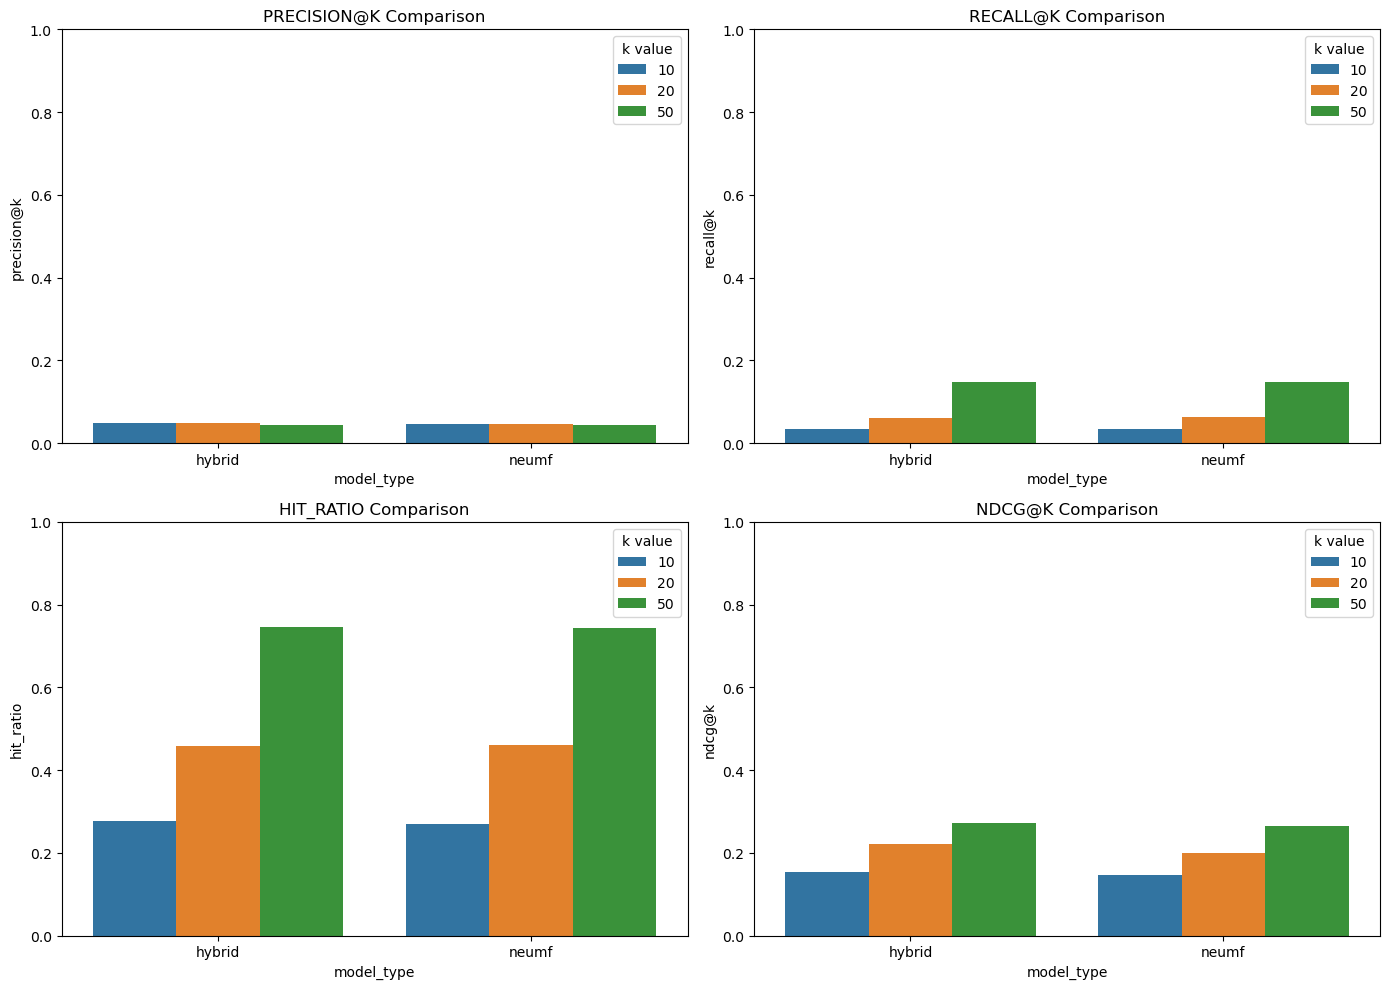


Hybrid Model Performance:
  model_type   k  precision@k  recall@k  hit_ratio    ndcg@k  users_evaluated
0     hybrid  10     0.048332  0.033605   0.277070  0.154429              942
2     hybrid  20     0.047710  0.060843   0.457537  0.220808              942
4     hybrid  50     0.044411  0.147619   0.745223  0.272725              942

Results saved to evaluation_results100k_20001.csv


In [76]:

import numpy as np
import pandas as pd
from sklearn.metrics import ndcg_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

class OptimizedEvaluator:
    @staticmethod
    def evaluate_model(recommender, test_data, train_data, k=10, model_type='hybrid', sample_size=None):
        """
        Improved evaluation with the ability to take a random sample and store temporary results.
        """
        # تحويل البيانات وتجهيزها
        test_df = pd.DataFrame(test_data[:, :2], columns=['user_id', 'movie_id'])
        train_df = pd.DataFrame(train_data[:, :2], columns=['user_id', 'movie_id'])
        
        # أخذ عينة عشوائية إذا طُلب
        if sample_size and sample_size < len(test_df['user_id'].unique()):
            users_sample = np.random.choice(test_df['user_id'].unique(), size=sample_size, replace=False)
            test_df = test_df[test_df['user_id'].isin(users_sample)]
        
        # تجميع التفاعلات
        train_user_items = train_df.groupby('user_id')['movie_id'].apply(set).to_dict()
        test_user_items = test_df.groupby('user_id')['movie_id'].apply(set).to_dict()
        
        # إعداد قوائم النتائج
        metrics = {
            'precision': [],
            'recall': [],
            'hit': 0,
            'ndcg': [],
            'users_processed': 0
        }
        
        # تقييم كل مستخدم مع شريط التقدم
        for user_id, test_items in tqdm(test_user_items.items(), desc=f'Evaluating {model_type} (k={k})'):
            try:
                # الحصول على التوصيات
                recs = OptimizedEvaluator._get_recommendations(
                    recommender, user_id, test_items, k, model_type
                )
                
                # تصفية العناصر المسبوقة
                seen_items = train_user_items.get(user_id, set())
                recs = [item for item in recs if item not in seen_items][:k]
                
                # حساب المقاييس
                relevant = len(test_items & set(recs))
                
                metrics['precision'].append(relevant / len(recs) if recs else 0)
                metrics['recall'].append(relevant / len(test_items) if test_items else 0)
                
                if relevant > 0:
                    metrics['hit'] += 1
                
                # حساب NDCG المعدل
                y_true = [1 if item in test_items else 0 for item in recs]
                if y_true:
                    if len(y_true) > 1:
                        metrics['ndcg'].append(ndcg_score([y_true], [range(len(y_true), 0, -1)], k=k))
                    else:
                        metrics['ndcg'].append(1.0 if y_true[0] == 1 else 0.0)
                
                metrics['users_processed'] += 1
                
            except Exception as e:
                continue
        
        # حساب المتوسطات
        return {
            'model_type': model_type,
            'k': k,
            'precision@k': np.mean(metrics['precision']) if metrics['precision'] else 0,
            'recall@k': np.mean(metrics['recall']) if metrics['recall'] else 0,
            'hit_ratio': metrics['hit'] / metrics['users_processed'] if metrics['users_processed'] > 0 else 0,
            'ndcg@k': np.mean(metrics['ndcg']) if metrics['ndcg'] else 0,
            'users_evaluated': metrics['users_processed']
        }
    
    @staticmethod
    def _get_recommendations(recommender, user_id, test_items, k, model_type):
        """مساعدة للحصول على التوصيات بناءً على نوع النموذج"""
        if model_type == 'hybrid':
            first_item = next(iter(test_items)) if test_items else None
            return [r['movieId'] for r in recommender.hybrid_recommend(
                user_id=int(user_id), 
                item_id=first_item, 
                k=k
            )]
        elif model_type == 'neumf':
            rec_items, _ = recommender.get_neu_mf_recommendations(int(user_id), k)
            return rec_items
        elif model_type == 'rule':
            if test_items:
                first_item = next(iter(test_items))
                rule_recs = recommender.get_rule_based_recommendations(first_item)
                return [r[0] for r in rule_recs][:k]
            return []
        elif model_type == 'knn':
            if test_items:
                first_item = next(iter(test_items))
                knn_recs = recommender.get_knn_recommendations(first_item, k)
                return [r[0] for r in knn_recs][:k]
            return []
        return []

def run_evaluation(hybrid_rec, y_ratings_train, y_ratings_test, k_values=[5, 10], sample_size=2000):
    """
    تشغيل التقييم مع إمكانية أخذ عينة وتخزين النتائج
    """
    results = []
    
    for k in k_values:
        print(f"\nEvaluation for k={k} (sample size: {sample_size})")
        
        for model_type in ['hybrid', 'neumf']:
            result = OptimizedEvaluator.evaluate_model(
                recommender=hybrid_rec,
                test_data=y_ratings_test,
                train_data=y_ratings_train,
                k=k,
                model_type=model_type,
                sample_size=sample_size
            )
            results.append(result)
            print(f"  - {model_type}: "
                  f"Precision@{k}={result['precision@k']:.3f}, "
                  f"Recall@{k}={result['recall@k']:.3f}, "
                  f"HitRatio={result['hit_ratio']:.3f}, "
                  f"NDCG@{k}={result['ndcg@k']:.3f}")
    
    return pd.DataFrame(results)

# تشغيل التقييم مع معالجة الأخطاء
try:
    # استخدم عينة أصغر للتحليل السريع (يمكن زيادة sample_size لتحسين الدقة)
    evaluation_results = run_evaluation(
        hybrid_rec=hybrid_rec,
        y_ratings_train=y_ratings_train,
        y_ratings_test=y_ratings_test,
        k_values=[10, 20, 50],
        sample_size=1000  # يمكن زيادتها إلى 2000 أو أكثر لتحسين الدقة
    )
    
    # تحليل النتائج
    print("\nFinal Results Summary:")
    print(evaluation_results[['model_type', 'k', 'precision@k', 'recall@k', 'hit_ratio', 'ndcg@k']])
    
    # تصور النتائج
    plt.figure(figsize=(14, 10))
    metrics = ['precision@k', 'recall@k', 'hit_ratio', 'ndcg@k']
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        sns.barplot(data=evaluation_results, x='model_type', y=metric, hue='k')
        plt.title(f'{metric.upper()} Comparison')
        plt.ylabel(metric)
        plt.ylim(0, 1)
        plt.legend(title='k value')
    
    plt.tight_layout()
    plt.savefig('model_comparison100k_20001.png')
    plt.show()
    
    # تحليل أداء النموذج الهجين
    hybrid_results = evaluation_results[evaluation_results['model_type'] == 'hybrid']
    print("\nHybrid Model Performance:")
    print(hybrid_results)
    
    # حفظ النتائج
    evaluation_results.to_csv('evaluation_results100k_20001.csv', index=False)
    print("\nResults saved to evaluation_results100k_20001.csv")

except Exception as e:
    print(f"\nEvaluation failed: {str(e)}")

In [75]:
# 1. تحميل البيانات
train_data = y_ratings_train  # شكل (n_samples, 3) [user_id, item_id, rating]
test_data = y_ratings_test    # نفس الشكل

# 2. إنشاء المقيّم
evaluator = HybridEvaluator()

# 3. التشغيل مع ضبط المعايير
results = evaluator.comprehensive_evaluate(
    hybrid_rec=hybrid_rec,
    train_data=train_data,
    test_data=test_data,
    k_values=[5, 10, 20],
    sample_size=2000
)

# 4. تحليل النتائج
print("\nالنتائج النهائية:")
print(results.groupby(['model_type', 'k']).mean())

# 5. تصور النتائج
plt.figure(figsize=(14, 6))
sns.barplot(data=results, x='model_type', y='ndcg', hue='k')
plt.title('مقارنة أداء النماذج بمقياس NDCG@K')
plt.show()

تحذير: يوجد 942 مستخدم متداخل بين التدريب والاختبار

=== تقييم لأعلى 5 توصيات ===
خطأ في تقييم المستخدم 94: Computing NDCG is only meaningful when there is more than 1 document. Got 1 instead.
فشل التقييم للنموذج hybrid: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
فشل التقييم للنموذج neumf: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
فشل التقييم للنموذج rule: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
فشل التقييم للنموذج knn: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

=== تقييم لأعلى 10 توصيات ===
فشل التقييم للنموذج hybrid: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
فشل التقييم للنموذج neumf: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
فشل التقييم للنموذج rule: The truth value of an array with more

KeyError: 'model_type'

In [ ]:
# def evaluate_hybrid(hybrid_model, test_data, batch_size=256, k=10, threshold=None):
#     """
#     نسخة معدلة تتكيف مع توزيع التقييمات الفعلي
#     """
#     if threshold is None:
#         # تحديد العتبة تلقائياً بناء على البيانات
#         unique_ratings = np.unique(test_data[:,2])
#         threshold = unique_ratings[-2] if len(unique_ratings) > 1 else unique_ratings[0]
    
#     test_users = np.unique(test_data[:,0])
#     results = {
#         'ndcg': [],
#         'hr': [],
#         'precision': [],
#         'recall': [],
#         'coverage': []
#     }
    
#     for user in test_users:
#         user_data = test_data[test_data[:,0] == user]
#         pos_items = user_data[user_data[:,2] >= threshold][:,1]
        
#         if len(pos_items) == 0:
#             continue
            
#         try:
#             # الحصول على التوصيات
#             recs = hybrid_model.hybrid_recommend(user_id=user, k=k)
#             rec_items = [r['movieId'] for r in recs]
#             rec_scores = [r['score'] for r in recs]
            
#             if not rec_items:
#                 continue
                
#             # حساب المقاييس
#             relevance = np.array([1 if item in pos_items else 0 for item in rec_items])
            
#             # NDCG
#             ideal = np.sort(relevance)[::-1]
#             results['ndcg'].append(ndcg_score([ideal], [relevance], k=k))
            
#             # Hit Ratio
#             results['hr'].append(1 if np.sum(relevance) > 0 else 0)
            
#             # Precision
#             results['precision'].append(np.sum(relevance) / k)
            
#             # Recall
#             results['recall'].append(np.sum(relevance) / len(pos_items))
            
#             # Coverage
#             results['coverage'].append(1)
            
#         except Exception as e:
#             print(f"Error with user {user}: {str(e)}")
#             continue
    
#     if not results['ndcg']:
#         print("تحذير: لا يوجد مستخدمون يلبي شروط التقييم")
#         return {k: 0 for k in results.keys()}
    
#     return {
#         'avg_ndcg': np.mean(results['ndcg']),
#         'avg_hr': np.mean(results['hr']),
#         'avg_precision': np.mean(results['precision']),
#         'avg_recall': np.mean(results['recall']),
#         'user_coverage': np.sum(results['coverage']) / len(test_users)
#     }

In [ ]:
# # تقييم على بيانات التحقق (Validation) أولاً
# print("\n=== التقييم على بيانات التحقق ===")
# val_metrics = evaluate_hybrid(
#     hybrid_rec,
#     y_ratings_val,
#     k=10
# )
# print(f"""
# نتائج التقييم (Validation):
# NDCG@10: {val_metrics['avg_ndcg']:.4f}
# HR@10: {val_metrics['avg_hr']:.4f}
# Precision@10: {val_metrics['avg_precision']:.4f}
# Recall@10: {val_metrics['avg_recall']:.4f}
# تغطية المستخدمين: {val_metrics['user_coverage']:.1%}
# """)

# # تقييم على بيانات الاختبار
# print("\n=== التقييم على بيانات الاختبار ===")
# test_metrics = evaluate_hybrid(
#     hybrid_rec,
#     y_ratings_test,
#     k=10
# )
# print(f"""
# نتائج التقييم (Test):
# NDCG@10: {test_metrics['avg_ndcg']:.4f}
# HR@10: {test_metrics['avg_hr']:.4f}
# Precision@10: {test_metrics['avg_precision']:.4f}
# Recall@10: {test_metrics['avg_recall']:.4f}
# تغطية المستخدمين: {test_metrics['user_coverage']:.1%}
# """)